<a href="https://colab.research.google.com/github/Zardian18/Transfer-Learning-and-TensorBoard/blob/master/04_transfer_learning_with_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TF: Feature Extraction

Transfer learning uses already build models and we can leverage it to fit our own needs

## Get data

In [1]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref= zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-08-13 15:53:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 172.253.117.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   270MB/s    in 0.6s    

2023-08-13 15:53:36 (270 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f'There are {len(dirnames)} directories and {len(filenames)} in "{dirpath}"')

There are 2 directories and 0 in "10_food_classes_10_percent"
There are 10 directories and 0 in "10_food_classes_10_percent/test"
There are 0 directories and 250 in "10_food_classes_10_percent/test/chicken_wings"
There are 0 directories and 250 in "10_food_classes_10_percent/test/ice_cream"
There are 0 directories and 250 in "10_food_classes_10_percent/test/steak"
There are 0 directories and 250 in "10_food_classes_10_percent/test/sushi"
There are 0 directories and 250 in "10_food_classes_10_percent/test/hamburger"
There are 0 directories and 250 in "10_food_classes_10_percent/test/ramen"
There are 0 directories and 250 in "10_food_classes_10_percent/test/fried_rice"
There are 0 directories and 250 in "10_food_classes_10_percent/test/chicken_curry"
There are 0 directories and 250 in "10_food_classes_10_percent/test/pizza"
There are 0 directories and 250 in "10_food_classes_10_percent/test/grilled_salmon"
There are 10 directories and 0 in "10_food_classes_10_percent/train"
There are 0 d

## Preprocessing data

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir= "10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

train_datagen= ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)


train_data_10_percent= train_datagen.flow_from_directory(directory=train_dir,
                                                         target_size=IMAGE_SHAPE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode="categorical")

test_data=test_datagen.flow_from_directory(directory=test_dir,
                                           target_size=IMAGE_SHAPE,
                                           batch_size=BATCH_SIZE,
                                           class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks

Three main we are going to use:

* Tracking experiments with Tensorboard callback
* Model checkpoint with ModelCheckPoint callback
* Stopping a model from overfitting with EarlyStopping Callback

### Create Tensorboard callback

In [4]:
import tensorflow_hub as hub
import tensorboard

In [5]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):

  log_dir= dir_name+"/"+ experiment_name+"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard Callbacks to {log_dir}")
  return tensorboard_callback

In [6]:
!mkdir model_testing

## Creating models using Tensorflow Hub


In [7]:
efficientnet_url="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"


In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
def create_model(model_url, num_classes=10):

  feature_extractor_layer= hub.KerasLayer(model_url,
                                          trainable=False,
                                          name="feature_extraction_layer",
                                          input_shape=IMAGE_SHAPE+(3,)) # Freezes already learnt patterns

  model=tf.keras.Sequential()
  model.add(feature_extractor_layer)
  model.add(tf.keras.layers.Dense(10, activation='softmax', name='output_layer'))

  return model

### resnet model with tensorflow hub



In [10]:
resnet_model=create_model(resnet_url)

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [13]:
history_resnet=resnet_model.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                callbacks=create_tensorboard_callback("model_testing", "resnet_train"))

Saving Tensorboard Callbacks to model_testing/resnet_train/20230813-155415
Epoch 1/5
24/24 [==============================] - 26s 552ms/step - loss: 1.9639 - accuracy: 0.3400 - val_loss: 1.2693 - val_accuracy: 0.5824
Epoch 2/5
24/24 [==============================] - 11s 479ms/step - loss: 0.9501 - accuracy: 0.7107 - val_loss: 0.8700 - val_accuracy: 0.7156
Epoch 3/5
24/24 [==============================] - 10s 448ms/step - loss: 0.6439 - accuracy: 0.8133 - val_loss: 0.7591 - val_accuracy: 0.7528
Epoch 4/5
24/24 [==============================] - 10s 447ms/step - loss: 0.5008 - accuracy: 0.8653 - val_loss: 0.7240 - val_accuracy: 0.7632
Epoch 5/5
24/24 [==============================] - 10s 448ms/step - loss: 0.3975 - accuracy: 0.9027 - val_loss: 0.6927 - val_accuracy: 0.7724


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_history(history):

  loss= history.history['loss']
  accuracy=history.history['accuracy']
  val_loss= history.history['val_loss']
  val_accuracy=history.history['val_accuracy']
  epoch= range(len(history.history['loss']))


  plt.plot(epoch, loss, label="Training loss")
  plt.plot(epoch, val_loss, label="Test loss")

  plt.figure()

  plt.plot(epoch, accuracy, label="Training accuracy")
  plt.plot(epoch, val_accuracy, label="Test accuracy")

  plt.legend();


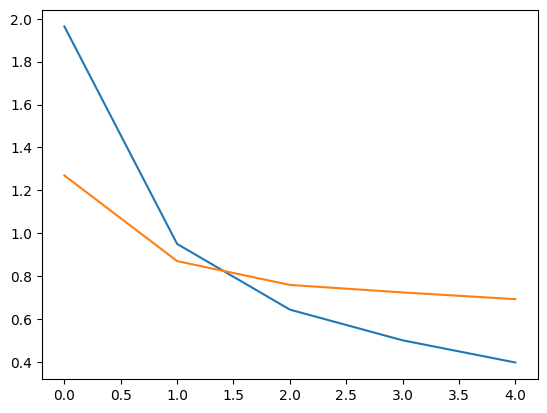

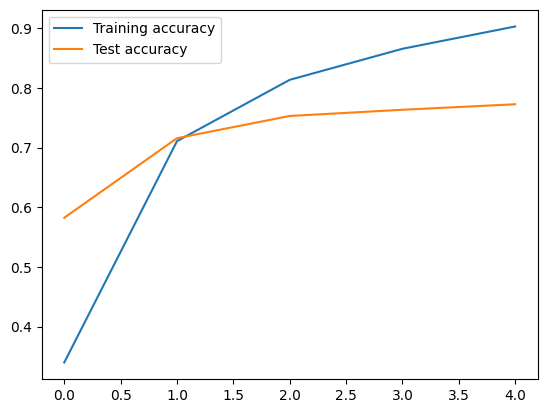

In [15]:
plot_history(history_resnet)

In [16]:
efficientnet_model= create_model(efficientnet_url)

In [17]:
efficientnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])


In [18]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [19]:
history_efficientnet= efficientnet_model.fit(train_data_10_percent,
                                             epochs=5,
                                             steps_per_epoch=len(train_data_10_percent),
                                             validation_data=test_data,
                                             validation_steps=len(test_data),
                                             callbacks=create_tensorboard_callback("model_testing","efficientnet"))

Saving Tensorboard Callbacks to model_testing/efficientnet/20230813-160809
Epoch 1/5
24/24 [==============================] - 26s 617ms/step - loss: 1.9068 - accuracy: 0.3893 - val_loss: 1.3462 - val_accuracy: 0.7024
Epoch 2/5
24/24 [==============================] - 10s 426ms/step - loss: 1.0790 - accuracy: 0.7813 - val_loss: 0.8886 - val_accuracy: 0.8172
Epoch 3/5
24/24 [==============================] - 10s 424ms/step - loss: 0.7662 - accuracy: 0.8373 - val_loss: 0.7124 - val_accuracy: 0.8376
Epoch 4/5
24/24 [==============================] - 10s 408ms/step - loss: 0.6155 - accuracy: 0.8653 - val_loss: 0.6250 - val_accuracy: 0.8492
Epoch 5/5
24/24 [==============================] - 23s 1s/step - loss: 0.5178 - accuracy: 0.8827 - val_loss: 0.5687 - val_accuracy: 0.8616


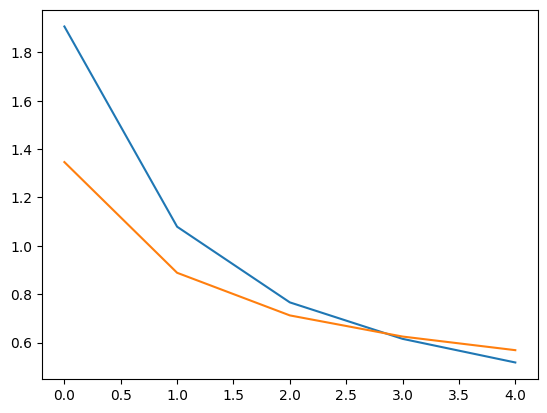

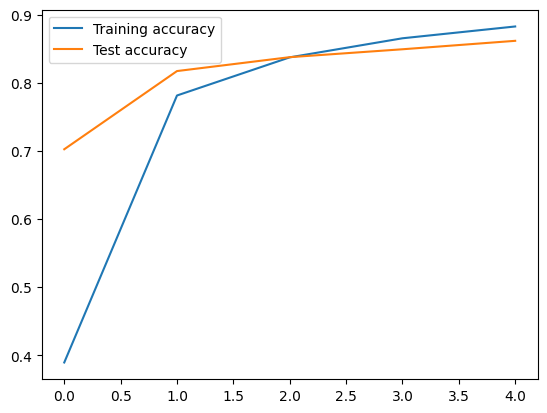

In [20]:
plot_history(history_efficientnet)

In [21]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [22]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Types of transfer learning

* **"As is"**: using existing model and making no changes
* **"Feature extraction"**: using prelearnt pattern of an existing model and adjust output layer accordingly
* **"Fine-Tuning"**: use prelearnt patterns and fine tune many or all underlying layers

In [23]:
len(efficientnet_model.layers[0].weights)

309

## Comparing our model's results using tensorboard

In [ ]:
# upload tensorboard dev records

!tensorboard dev upload --logdir ./model_testing/ \
--name "EfficientNetB0 vs Resnet50V2" \
--description "Comparing two different TF hub feature extraction" \
--one_shot

## Tensorboard Experiments:

link: https://tensorboard.dev/experiment/M2X3DeBLTZOqu4CBWNA6PQ/

In [25]:
!tensorboard dev list

2023-08-13 16:52:22.187706: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/M2X3DeBLTZOqu4CBWNA6PQ/
	Name                 EfficientNetB0 vs Resnet50V2
	Description          Comparing two different TF hub feature extraction
	Id                   M2X3DeBLTZOqu4CBWNA6PQ
	Created              2023-08-13 16:47:14 (5 minutes ago)
	Updated              2023-08-13 16:47:16 (5 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5811169
Total: 1 experiment(s)
